# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.286160
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.138109 analytic: 1.138109, relative error: 5.659742e-08
numerical: -3.218544 analytic: -3.218544, relative error: 1.782991e-08
numerical: 1.691509 analytic: 1.691509, relative error: 1.059737e-08
numerical: -3.375061 analytic: -3.375061, relative error: 6.945477e-09
numerical: -1.736176 analytic: -1.736176, relative error: 4.871533e-08
numerical: -1.297688 analytic: -1.297688, relative error: 1.987391e-08
numerical: 0.360056 analytic: 0.360056, relative error: 4.523833e-08
numerical: -2.508038 analytic: -2.508038, relative error: 2.514132e-08
numerical: 0.370552 analytic: 0.370552, relative error: 5.235906e-08
numerical: -1.232206 analytic: -1.232206, relative error: 2.185797e-08
numerical: -1.993985 analytic: -1.993985, relative error: 7.524525e-09
numerical: -2.364627 analytic: -2.364627, relative error: 1.996564e-08
numerical: -1.379800 analytic: -1.379800, relative error: 7.517953e-08
numerical: -1.688418 analytic: -1.688418, relative error: 5.251078e-09
numerical: -1.

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.286160e+00 computed in 0.043310s
vectorized loss: 2.286160e+00 computed in 0.004183s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = 10**(-1*np.random.uniform(5,8,10))
regularization_strengths = 10**np.random.uniform(2,6,10)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for ii in xrange(len(learning_rates)):
    for jj in xrange(len(regularization_strengths)):
        softmax = Softmax()
        lr = learning_rates[ii]
        reg = regularization_strengths[jj]
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                                  num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 14.087161
iteration 100 / 1500: loss 12.372379
iteration 200 / 1500: loss 11.710628
iteration 300 / 1500: loss 11.799659
iteration 400 / 1500: loss 11.048481
iteration 500 / 1500: loss 10.972248
iteration 600 / 1500: loss 10.559743
iteration 700 / 1500: loss 10.659601
iteration 800 / 1500: loss 10.265493
iteration 900 / 1500: loss 10.108228
iteration 1000 / 1500: loss 10.003599
iteration 1100 / 1500: loss 9.850938
iteration 1200 / 1500: loss 9.652920
iteration 1300 / 1500: loss 9.694407
iteration 1400 / 1500: loss 9.221671
iteration 0 / 1500: loss 10.808300
iteration 100 / 1500: loss 8.871245
iteration 200 / 1500: loss 8.170617
iteration 300 / 1500: loss 7.858514
iteration 400 / 1500: loss 7.596320
iteration 500 / 1500: loss 7.412405
iteration 600 / 1500: loss 7.043705
iteration 700 / 1500: loss 7.304590
iteration 800 / 1500: loss 7.198732
iteration 900 / 1500: loss 6.979493
iteration 1000 / 1500: loss 6.758621
iteration 1100 / 1500: loss 6.688478
iteration 120

cs231n/classifiers/softmax.py:91: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(score[range(num_samp),y] / f))
cs231n/classifiers/softmax.py:89: RuntimeWarning: overflow encountered in exp
  score = np.exp(np.dot(X,W))
cs231n/classifiers/softmax.py:94: RuntimeWarning: invalid value encountered in divide
  p = score / np.reshape(f,[-1,1])


iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1517.306235
iteration 100 / 1500: loss 2.295382
iteration 200 / 1500: loss 2.235586
iteration 300 / 1500: loss 2.415794
iteration 400 / 1500: loss 2.417532
iteration 500 / 1500: loss 2.234929
iteration 600 / 1500: loss 2.308794
iteration 700 / 1500: loss 2.243359
iteration 800 / 1500: loss 2.238727
iteration 900 / 1500: loss 2.260181
iteration 1000 / 1500: loss 2.334625
iteration 1100 / 1500: loss 2.358883
iteration 1200 / 1500: loss 2.190755
iteration 1300 / 1500: loss 2.449619
iteration 1400 / 1500: loss 2.332005
iteration 0 / 1

cs231n/classifiers/softmax.py:91: RuntimeWarning: invalid value encountered in divide
  loss = np.sum(-np.log(score[range(num_samp),y] / f))


iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 828.915973
iteration 100 / 1500: loss 2.197375
iteration 200 / 1500: loss 2.268246
iteration 300 / 1500: loss 2.173820
iteration 400 / 1500: loss 2.203191
iteration 500 / 1500: loss 2.167902
iteration 600 / 1500: loss 2.207461
iteration 700 / 1500: loss 2.235124
iteration 800 / 1500: loss 2.216528
iteration 900 / 1500: loss 2.113033
iteration 1000 / 1500: loss 2.271608
iteration 1100 / 1500: loss 2.161971
iteration 1200 / 1500: loss 2.114814
iteration 1300 / 1500: loss 2.160546
iteration 1400 / 1500: loss 2.202585
iteration 0 / 15

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.370000


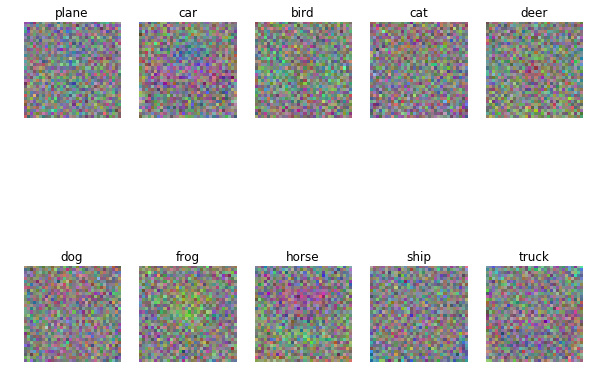

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])